# 4.1 Rumelhart Semantic Network
> Note, the code in this notebook trains a network and may take a while to run. To save time, you can run the full notebook now while reading the introduction. Then, don't rerun each cell while going through the notebook since that might reset the training.

## Introduction

### Multilayer NN in Psychology: Semantics
  
Our minds are full of associations, presumably implemented as connection strengths between concepts. But associations can have a wide variety of structure -- they are not merely symmetric (e.g. "dog" and "mail carrier" are associated but have an asymmetric relationship -- the mail carrier is less likely to bite the dog than vice a versa). Semantic networks are graphs used to model the relationships between concepts in the mind, and are a commonly used representation of knowledge. They are depicted as graphs, whose vertices are concepts and whose edges represent connections between concepts. A concept that is a noun is connected to its characteristics, but also to categories that it is a member of. Nouns that share a category (e.g. birds and dogs are both animals) both have a connection to that category, and share a higher-order connection between that category and a category to which it belongs (e.g. animals belong to the category living things).  
  
In this way, semantic nets can contain a deductive logical hierarchy. One of the key features arising from this hierarchy is the "inheritance" property, which states that a concept belonging to a subcategory will inherit the properties of that subcategory and, by extension, any category to which the subcategory belongs.    
  
To clarify, consider hearing the phrase "Blue-Footed Booby" for the first time. Initially, it contains very little information. If you are then told that it is the name of a bird, you'll know that it must necessarily have feathers, a beak, feet, and eyes. You will also know that it is a living thing, and therefore grows and is comprised of cells. This is the inheritance property at work.  

![semantic net example](semantic-example.png)
  
  
Dave Rumelhart used neural networks to model semantic networks, recreating structured knowledge representations using hidden layers and backprop learning.  
  
In order to represent the semantic net computationally, Rumelhart came up with a particularly clever structure of a multi-layer network, with two input layers, two hidden layers, and four output layers.  
  
![semantic net architecture](semantic-architecture.png)
  
When training networks of this structure, it was found that the represenational nodes, when adequately trained, came to represent distinguishing features of their inputs. They were internal representations of the concepts similar to those created in the human mind.  
  
Let us explore his idea by building it ourselves.

**Installation and Setup**

In [86]:
%%capture
%pip install psyneulink

import numpy as np
import psyneulink as pnl
import matplotlib.pyplot as plt 

##  Rumelhart's Semantic Network 

The first thing we will do is create a data set with examples and labels that we can train the net on. We'll be using a similar data set to the one in Rumelhart's original paper on the semantic net [Rumelhart, Hinton, and Williams (1986)](https://princetonuniversity.github.io/NEU-PSY-502/_static/pdf/Class%209/Rumelhart1986.pdf).  

The "nouns" inputs are provided to you in a list, as are the "relations". The relations consist of "I", which is simply the list of nouns, "is" which is a list of largest categories to which the noun can belong, "has", which are potential physical attributes, and "can", which are abilities each noun possesses.  
  
The network takes as input a pair of nouns and relations, which form a priming statement, such as "daisy is a", and should produce a response from the network that includes both a list of what a daisy is, and lists of what a daisy has and can do, as well as the actual term "daisy". This response mimics the brain's priming response, by creating activation for concepts related to the one explicitly stated.  
  
This is a slightly simplified model of Rumelhart's network, which learned associations through internal structure only, not through explicit updating for every output.

In [77]:
# Stimuli and Relations

nouns = ['oak', 'pine', 'rose', 'daisy', 'canary', 'robin', 'salmon', 'sunfish']
relations = ['is', 'has', 'can']
is_list = ['living', 'living thing', 'plant', 'animal', 'tree', 'flower', 'bird', 'fish', 'big', 'green', 'red',
           'yellow']
has_list = ['roots', 'leaves', 'bark', 'branches', 'skin', 'feathers', 'wings', 'gills', 'scales']
can_list = ['grow', 'move', 'swim', 'fly', 'breathe', 'breathe underwater', 'breathe air', 'walk', 'photosynthesize']
descriptors = [nouns, is_list, has_list, can_list]

truth_nouns = np.identity(len(nouns))

truth_is = np.zeros((len(nouns), len(is_list)))

truth_is[0, :] = [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
truth_is[1, :] = [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
truth_is[2, :] = [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
truth_is[3, :] = [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0] # <--- Exercise 1a What does this row represent?
truth_is[4, :] = [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
truth_is[5, :] = [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
truth_is[6, :] = [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]
truth_is[7, :] = [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]

truth_has = np.zeros((len(nouns), len(has_list)))

truth_has[0, :] = [1, 1, 1, 1, 0, 0, 0, 0, 0]
truth_has[1, :] = [1, 1, 1, 1, 0, 0, 0, 0, 0]
truth_has[2, :] = [1, 1, 0, 0, 0, 0, 0, 0, 0]
truth_has[3, :] = [1, 1, 0, 0, 0, 0, 0, 0, 0]
truth_has[4, :] = [0, 0, 0, 0, 1, 1, 1, 0, 0]
truth_has[5, :] = [0, 0, 0, 0, 1, 1, 1, 0, 0]
truth_has[6, :] = [0, 0, 0, 0, 0, 0, 0, 1, 1] # <--- Exercise 1b What does this row represent?
truth_has[7, :] = [0, 0, 0, 0, 0, 0, 0, 1, 1]

truth_can = np.zeros((len(nouns), len(can_list)))

truth_can[0, :] = [1, 0, 0, 0, 0, 0, 0, 0, 1]
truth_can[1, :] = [1, 0, 0, 0, 0, 0, 0, 0, 1] # <--- Exercise 1c What does this row represent?
truth_can[2, :] = [1, 0, 0, 0, 0, 0, 0, 0, 1]
truth_can[3, :] = [1, 0, 0, 0, 0, 0, 0, 0, 1]
truth_can[4, :] = [1, 1, 0, 1, 1, 0, 1, 1, 0]
truth_can[5, :] = [1, 1, 0, 1, 1, 0, 1, 1, 0]
truth_can[6, :] = [1, 1, 1, 0, 1, 1, 0, 0, 0]
truth_can[7, :] = [1, 1, 1, 0, 1, 1, 0, 0, 0]

truths = [[truth_nouns], [truth_is], [truth_has], [truth_can]]

#### Exercise 1{exercise}

In the above code, there are three rows that are marked with comments. For each of these rows, identify the noun that it represents, and explain what the row is representing.

Exercise 1a

Remember:
```python
nouns = ['oak', 'pine', 'rose', 'daisy', 'canary', 'robin', 'salmon', 'sunfish']
relations = ['is', 'has', 'can']
is_list = ['living', 'living thing', 'plant', 'animal', 'tree', 'flower', 'bird', 'fish', 'big', 'green', 'red',
           'yellow']
has_list = ['roots', 'leaves', 'bark', 'branches', 'skin', 'feathers', 'wings', 'gills', 'scales']
can_list = ['grow', 'move', 'swim', 'fly', 'breathe', 'breathe underwater', 'breathe air', 'walk', 'photosynthesize']
```

what does the row `truth_is[3, :]` represent?

```python
truth_is[3, :] = [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
```

Solution 1a{solution}

The 3 in `truth_is[3, :]` refers to the 4th noun in the list of nouns (remember indexing in Python starts with 0), which is "daisy".

[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0] can be interpreted as a list of 12 booleans, where 1 means true and 0 means false. We map this to the is_list, which is a list of 12 concepts.

That means:

- 1: "daisy" is a living thing
- 1: "daisy" is a living
- 1: "daisy" is a plant
- 0: "daisy" is not an animal
- 0: "daisy" is not a tree
- 1: "daisy" is a flower
- 0: "daisy" is not a bird
- 0: "daisy" is not a fish
- 0: "daisy" is not big
- 0: "daisy" is not green
- 0: "daisy" is not red
- 0: "daisy" is not yellow

Exercise 1b

Remember:
```python
nouns = ['oak', 'pine', 'rose', 'daisy', 'canary', 'robin', 'salmon', 'sunfish']
relations = ['is', 'has', 'can']
is_list = ['living', 'living thing', 'plant', 'animal', 'tree', 'flower', 'bird', 'fish', 'big', 'green', 'red',
           'yellow']
has_list = ['roots', 'leaves', 'bark', 'branches', 'skin', 'feathers', 'wings', 'gills', 'scales']
can_list = ['grow', 'move', 'swim', 'fly', 'breathe', 'breathe underwater', 'breathe air', 'walk', 'photosynthesize']
```

what does the row `truth_has[6, :]` represent?
```python
truth_has[6, :] = [0, 0, 0, 0, 0, 0, 0, 1, 1]
```

Solution 1b{solution}

- salmon does not have roots
- salmon does not have leaves
- salmon does not have a bark
- salmon does not have branches
- salmon does not have skin
- salmon does not have feathers
- salmon does not have wings
- salmon has gills
- salmon has scales

Exercise 1c

Remember:
```python
nouns = ['oak', 'pine', 'rose', 'daisy', 'canary', 'robin', 'salmon', 'sunfish']
relations = ['is', 'has', 'can']
is_list = ['living', 'living thing', 'plant', 'animal', 'tree', 'flower', 'bird', 'fish', 'big', 'green', 'red',
           'yellow']
has_list = ['roots', 'leaves', 'bark', 'branches', 'skin', 'feathers', 'wings', 'gills', 'scales']
can_list = ['grow', 'move', 'swim', 'fly', 'breathe', 'breathe underwater', 'breathe air', 'walk', 'photosynthesize']
```

what does the row `truth_can[1, :]` represent?
```python
truth_can[1, :] = [1, 0, 0, 0, 0, 0, 0, 0, 1]
```

Solution 1c{solution}

- pine can grow
- pine cannot move
- pine cannot swim
- pine cannot fly
- pine cannot breathe
- pine cannot breathe underwater
- pine cannot breathe air
- pine cannot walk
- pine can photosynthesize

### Create the Inputs Set

Here, we will create the input set for each of the nouns and relations. We will use one-hot encoding to represent the nouns and relations. Additionally, we will add single constant input to each of the vectors that will be used as a bias input for the network.

In [78]:
def gen_input_vals(nouns, relations):

    rumel_nouns_bias=np.vstack((np.identity(len(nouns)),np.ones((1,len(nouns)))))
    rumel_nouns_bias=rumel_nouns_bias.T

    rumel_rels_bias=np.vstack((np.identity(len(relations)),np.ones((1,len(relations)))))
    rumel_rels_bias=rumel_rels_bias.T
    return (rumel_nouns_bias, rumel_rels_bias)

nouns_onehot, rels_onehot = gen_input_vals(nouns, relations)

r_nouns = np.shape(nouns_onehot)[0]
c_nouns = np.shape(nouns_onehot)[1]
r_rels = np.shape(rels_onehot)[0]
c_rels = np.shape(rels_onehot)[1]

print('Nouns Onehot\n:', nouns_onehot)

print('\nRelations Onehot\n:', rels_onehot)

print('\nNouns Shape:\n', np.shape(nouns_onehot))

print('\nRelations Shape:\n', np.shape(rels_onehot))


Nouns Onehot
: [[1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]

Relations Onehot
: [[1. 0. 0. 1.]
 [0. 1. 0. 1.]
 [0. 0. 1. 1.]]

Nouns Shape:
 (8, 9)

Relations Shape:
 (3, 4)


#### Exercise 2{exercise}

Exercise 2a

This is the tensor `nouns_onehot` that was generated by the function `gen_input_vals`. What does the marked line represent?:

```
[[1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1.] 
 [0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1.] # <-- Exercise 2a
 [0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]
```

Solution 2a{solution}

The marked line represents the biased input for `robin`. The `1` at the 6th index represents the activation for `robin` and the `1` at the 9th index represents the bias input.

Exercise 2b

There seems to be a pattern in the shapes of the tensors:

- `nouns_onehot` has a shape of `(8, 9)`
- `rels_onehot` has a shape of `(3, 4)`

The general form of the shape seems to be (i, i+1)

Can you explain what the `i` is and why the shape of the tensors is in this form?

Solution 2b{solution}

The `i` is the number of elements. Without a bias term the tensor would be of shape `(i, i)` and look like an identity matrix. Since we add a bias term to each vector, the length of each vector increases by 1, but we still have `i` elements. This is why the shape of the tensors is `(i, i+1)`.

### Create the Network

Now, we can set up the network according to Rumelhart's architecture (see picture above).

First, let's create the ***layers***:

In [189]:
# Create the input layers

input_nouns = pnl.TransferMechanism(name="input_nouns",
                                    input_shapes=c_nouns,
                                    )

input_relations = pnl.TransferMechanism(name="input_relations",
                                        input_shapes=c_rels,
                                        )

# Create the hidden layers. Here we use a logistic activation function
# The number of hidden units is taken directly from Rumelhart's paper
hidden_nouns_units = 9
hidden_mixed_units = 16

hidden_nouns = pnl.TransferMechanism(name="hidden_nouns",
                                     input_shapes=hidden_nouns_units,
                                     function=pnl.Logistic()
                                     )

hidden_mixed = pnl.TransferMechanism(name="hidden_mixed",
                                     input_shapes=hidden_mixed_units,
                                     function=pnl.Logistic()
                                     )

# Create the output layers. Here we use a logistic activation function

output_I = pnl.TransferMechanism(name="output_I",
                                 input_shapes=len(nouns),
                                 function=pnl.Logistic()
                                 )

output_is = pnl.TransferMechanism(name="output_is",
                                  input_shapes=len(is_list),
                                  function=pnl.Logistic()
                                  )

output_has = pnl.TransferMechanism(name="output_has",
                                   input_shapes=len(has_list),
                                   function=pnl.Logistic()
                                   )

output_can = pnl.TransferMechanism(name="output_can",
                                   input_shapes=len(can_list),
                                   function=pnl.Logistic()
                                   )

Then, we can create the ***projections*** between the layers. We will use random matrices to connect the mechanisms to each other.

In [190]:
# Seed for reproducibility
np.random.seed(42)

# First, we create the projections from the input layers

# input_nouns -> hidden_nouns
map_in_nouns_h_nouns = pnl.MappingProjection(
    matrix=np.random.rand(c_nouns, hidden_nouns_units),
    name="map_in_nouns_h_nouns",
    sender=input_nouns,
    receiver=hidden_nouns
)

# input_relations -> hidden_mixed
map_in_rel_h_mixed = pnl.MappingProjection(
    matrix=np.random.rand(c_rels, hidden_mixed_units),
    name="map_in_rel_h_mixed",
    sender=input_relations,
    receiver=hidden_mixed
)

# Then, we create the projections between the hidden layers

# hidden_nouns -> hidden_mixed
map_h_nouns_h_mixed = pnl.MappingProjection(
    matrix=np.random.rand(hidden_nouns_units, hidden_mixed_units),
    name="map_h_nouns_h_mixed",
    sender=hidden_nouns,
    receiver=hidden_mixed
)

# Finally, we create the projections from the hidden layers to the output layers

# hidden_mixed -> output_I
map_h_mixed_out_I = pnl.MappingProjection(
    matrix=np.random.rand(hidden_mixed_units, len(nouns)),
    name="map_h_mixed_out_I",
    sender=hidden_mixed,
    receiver=output_I
)

# hidden_mixed -> output_is
map_h_mixed_out_is = pnl.MappingProjection(
    matrix=np.random.rand(hidden_mixed_units, len(is_list)),
    name="map_hm_is",
    sender=hidden_mixed,
    receiver=output_is
)

# hidden_mixed -> output_has
map_h_mixed_out_can = pnl.MappingProjection(
    matrix=np.random.rand(hidden_mixed_units, len(has_list)),
    name="map_h_mixed_out_can",
    sender=hidden_mixed,
    receiver=output_can
)

map_h_mixed_out_has = pnl.MappingProjection(
    matrix=np.random.rand(hidden_mixed_units, len(has_list)),
    name="map_h_mixed_out_has",
    sender=hidden_mixed,
    receiver=output_has
)

Finally, we create the composition. Here, we use `pnl.AutoDiffComposition` to build a network capable of learning. This subclass of `pnl.Composition` is primarily designed for the efficient training of ***feedforward*** neural networks. It is mostly restricted to ***supervised*** learning, specifically using ***backpropagation***. 

We then add all nodes and projections to the network and configure the logging conditions for the outputs.

In [191]:
learning_rate = 1
# Create the AutoDiffComposition with the pathways

rumelhart_net = pnl.AutodiffComposition(
    pathways=[[input_nouns, map_in_nouns_h_nouns, hidden_nouns],
              [input_relations, map_in_rel_h_mixed, hidden_mixed],
              [hidden_nouns, map_h_nouns_h_mixed, hidden_mixed],
              [hidden_mixed, map_h_mixed_out_I, output_I],
              [hidden_mixed, map_h_mixed_out_is, output_is],
              [hidden_mixed, map_h_mixed_out_has, output_has],
              [hidden_mixed, map_h_mixed_out_can, output_can]],
    learning_rate=learning_rate
)

rumelhart_net.show_graph(output_fmt='jupyter')

### Training the Network

We aim to train our network on input pairs consisting of a noun and a relation.
 
On each run, we want to:

1. Set the targets for the **relevant outputs** to their corresponding truth tables.
2. Set the targets for the **irrelevant outputs** to zero.

**Understanding the Concept**

Imagine someone asks you which attributes from the "has" list a **robin** possesses. You would likely answer **correctly** by listing relevant attributes. However, you wouldn’t mention anything from the "can" list, since those attributes  are **not relevant** to the question.

**Why is this important?**

This mirrors how we naturally learn. In elementary school, when asked a  **simple, closed-form question**, we weren’t rewarded for giving a response that was **related but didn't actually answer the question**.

For example:

**Q:** *Can a canary fly?*  

**True but irrelevant answer:** *A canary is a yellow living thing with wings that can breathe air.*  
 
While this statement is **true**, it **does not directly answer the question**. Our goal is to train the network in the same way—to **focus on relevant responses**.

***Note***, the following code will take a while to run. 

In [203]:
# First, let's create zero arrays for the irrelevant outputs.
is_ir = np.zeros(len(is_list))
has_ir = np.zeros(len(has_list))
can_ir = np.zeros(len(can_list))

# We will train the model for `n_epochs` epochs and `tot_reps` repetitions
n_epochs = 5
tot_reps = 50

# Repeat th training for `tot_reps` repetitions
for reps in range(tot_reps):
    
    # Loop through each noun
    for noun in range(len(nouns)):
        # Here, we will store the inputs and targets in dictionaries
        inputs_dict = {
            input_nouns: [],
            input_relations: []
        }

        # Here, we will store the respective targets in dictionaries
        targets_dict = {
            output_I: [],
            output_is: [],
            output_has: [],
            output_can: []
        }

        # Loop through each relation
        for i in range(len(relations)):
            # Append the input to the dictionary
            inputs_dict[input_nouns].append(nouns_onehot[noun])
            inputs_dict[input_relations].append(rels_onehot[i])

            # Append the targets to the dictionary
            targets_dict[output_I].append(truth_nouns[noun])
            targets_dict[output_is].append(truth_is[noun] if i == 0 else is_ir)  # i == 0 -> "is" relation 
            targets_dict[output_has].append(truth_has[noun] if i == 1 else has_ir)  # i == 1 -> "has" relation
            targets_dict[output_can].append(truth_can[noun] if i == 2 else can_ir)  # i == 2 -> "can" relation
        
        # Train the network for `n_epochs`
        result = rumelhart_net.learn(
            inputs={
                'inputs': inputs_dict,
                'targets': targets_dict,
                'epochs': n_epochs
            },
            execution_mode=pnl.ExecutionMode.PyTorch
        )
    
    # Print a dot for each repetition to track progress
    print('.', end='')
    # Print a new line every 10 repetitions
    if (reps + 1) % 10 == 0:
        print()

..........
..........
..........
..........
..........


The above block of code trains the network using a set of three loops. The innermost pair of loops takes each noun and creates the appropriate training inputs and outputs associated with its "is", "has", and "can" relations. It will also be associated with an identity output. 

After constructing the dictionaries, the middle loop, associated with the nouns, trains the network on the dictionaries for n_epochs. 

The outermost loop simply repeats the training on each noun for a set number of repetitions. 

***You are encouraged to experiment with changing the number of repetitions and epochs to see how the network learns best.*** 

### Evaluating the Network

We now print the losses of the network over time. 

last lost was:  [0.01592901]


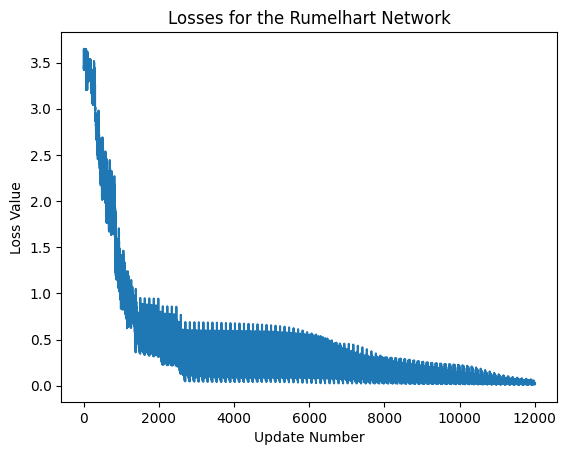

In [221]:
exec_id = rumelhart_net.default_execution_id
losses = rumelhart_net.parameters.torch_losses.get(exec_id)

plt.xlabel('Update Number')
plt.ylabel('Loss Value')
plt.title('Losses for the Rumelhart Network')
plt.plot(losses)
print('last lost was: ',losses[-1])

### Inference

On top of the loss, let's test what output the network gives for a given input.

In [205]:
# Pick a random id

noun_id = np.random.randint(0, len(nouns)-1)

relations_id = np.random.randint(0, len(relations)-1)

input_dict = {
    input_nouns: [nouns_onehot[noun_id]],
    input_relations: [rels_onehot[relations_id]]
}

answer = rumelhart_net.run(input_dict)

print(f'What {relations[relations_id]} {nouns[noun_id]}?')

print(f'{nouns[np.argmax(answer[0])]}...')

for idx, el in enumerate(answer[1]):
    if el > 0.5:
        print(f'is {is_list[idx]}')
        
for idx, el in enumerate(answer[2]):
    if el > 0.5:
        print(f'has {has_list[idx]}')
        
for idx, el in enumerate(answer[3]):
    if el > 0.5:
        print(f'can {can_list[idx]}')


What is salmon?
salmon...
is living
is living thing
is animal
is fish
is big
is red


#### Exercise 3{exercise}

When asked the question "What is a robin?", answering "a robin can fly" is not the most relevant response, but it is not "as false as saying "a robin is a fish".

Ty training the following network to be sometimes answer "a robin can fly" although it is not the most relevant response.

In [206]:
rumelhart_net_with_ir = pnl.AutodiffComposition(
    pathways=[[input_nouns, map_in_nouns_h_nouns, hidden_nouns],
              [input_relations, map_in_rel_h_mixed, hidden_mixed],
              [hidden_nouns, map_h_nouns_h_mixed, hidden_mixed],
              [hidden_mixed, map_h_mixed_out_I, output_I],
              [hidden_mixed, map_h_mixed_out_is, output_is],
              [hidden_mixed, map_h_mixed_out_has, output_has],
              [hidden_mixed, map_h_mixed_out_can, output_can]],
    learning_rate=learning_rate
)

In [207]:
# implement your code here

Solution 3{solution}

Instead of setting the values of the irrelevant outputs to zero, we just "discount" them by a factor of .5. This way, the network will learn to give more weight to the relevant outputs, but will still learn to give some weight to the irrelevant but true outputs.

```python
# We will train the model for `n_epochs` epochs and `tot_reps` repetitions
n_epochs = 5
tot_reps = 200

# Repeat th training for `tot_reps` repetitions
for reps in range(tot_reps):
    
    # Loop through each noun
    for noun in range(len(nouns)):
        # Here, we will store the inputs and targets in dictionaries
        inputs_dict = {
            input_nouns: [],
            input_relations: []
        }

        # Here, we will store the respective targets in dictionaries
        targets_dict = {
            output_I: [],
            output_is: [],
            output_has: [],
            output_can: []
        }

        # Loop through each relation
        for i in range(len(relations)):
            # Append the input to the dictionary
            inputs_dict[input_nouns].append(nouns_onehot[noun])
            inputs_dict[input_relations].append(rels_onehot[i])

            # Append the targets to the dictionary
            targets_dict[output_I].append(truth_nouns[noun])
            targets_dict[output_is].append(truth_is[noun] if i == 0 else truth_is[noun]*.5)  # i == 0 -> "is" relation but instead of 0 we use .5 if irrelevant
            targets_dict[output_has].append(truth_has[noun] if i == 1 else truth_has[noun]*.5)  # i == 1 -> "has" relation but instead of 0 we use .5 if irrelevant
            targets_dict[output_can].append(truth_can[noun] if i == 2 else truth_can[noun]*.5)  # i == 2 -> "can" relation but instead of 0 we use .5 if irrelevant
        
        # Train the network for `n_epochs`
        result = rumelhart_net_with_ir.learn(
            inputs={
                'inputs': inputs_dict,
                'targets': targets_dict,
                'epochs': n_epochs
            },
            execution_mode=pnl.ExecutionMode.PyTorch
        )
    
    # Print a dot for each repetition to track progress
    print('.', end='')
    # Print a new line every 10 repetitions
    if (reps + 1) % 10 == 0:
        print()
```


In [214]:
n_epochs = 5
tot_reps = 50

# Repeat th training for `tot_reps` repetitions
for reps in range(tot_reps):
    
    # Loop through each noun
    for noun in range(len(nouns)):
        # Here, we will store the inputs and targets in dictionaries
        inputs_dict = {
            input_nouns: [],
            input_relations: []
        }

        # Here, we will store the respective targets in dictionaries
        targets_dict = {
            output_I: [],
            output_is: [],
            output_has: [],
            output_can: []
        }

        # Loop through each relation
        for i in range(len(relations)):
            # Append the input to the dictionary
            inputs_dict[input_nouns].append(nouns_onehot[noun])
            inputs_dict[input_relations].append(rels_onehot[i])

            # Append the targets to the dictionary
            targets_dict[output_I].append(truth_nouns[noun])
            targets_dict[output_is].append(truth_is[noun] if i == 0 else truth_is[noun]*.5)  # i == 0 -> "is" relation but instead of 0 we use .5 if irrelevant
            targets_dict[output_has].append(truth_has[noun] if i == 1 else truth_has[noun]*.5)  # i == 1 -> "has" relation but instead of 0 we use .5 if irrelevant
            targets_dict[output_can].append(truth_can[noun] if i == 2 else truth_can[noun]*.5)  # i == 2 -> "can" relation but instead of 0 we use .5 if irrelevant
        
        # Train the network for `n_epochs`
        result = rumelhart_net_with_ir.learn(
            inputs={
                'inputs': inputs_dict,
                'targets': targets_dict,
                'epochs': n_epochs
            },
            execution_mode=pnl.ExecutionMode.PyTorch
        )
    
    # Print a dot for each repetition to track progress
    print('.', end='')
    # Print a new line every 10 repetitions
    if (reps + 1) % 10 == 0:
        print()

..........
..........
..........
..........
..........


### Evaluating the Network

last lost was:  [0.00798728]


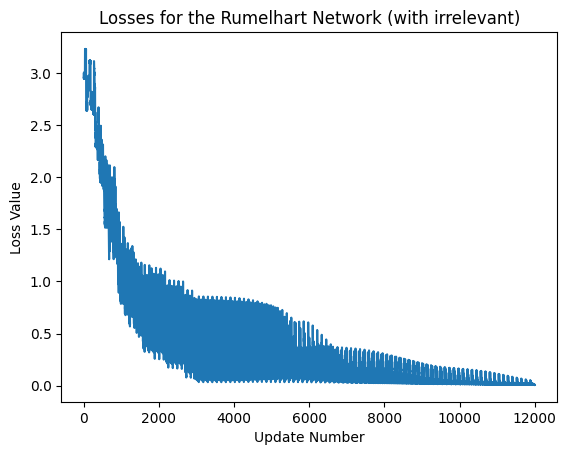

In [220]:
exec_id = rumelhart_net_with_ir.default_execution_id
losses = rumelhart_net_with_ir.parameters.torch_losses.get(exec_id)

plt.xlabel('Update Number')
plt.ylabel('Loss Value')
plt.title('Losses for the Rumelhart Network (with irrelevant)')
plt.plot(losses)
print('last lost was: ',losses[-1])

After training the network, examine the output of the network for a given input.

In [216]:
# Pick a random id

noun_id = np.random.randint(0, len(nouns)-1)

relations_id = np.random.randint(0, len(relations)-1)

input_dict = {
    input_nouns: [nouns_onehot[noun_id]],
    input_relations: [rels_onehot[relations_id]]
}

answer = rumelhart_net_with_ir.run(input_dict)

print(f'What {relations[relations_id]} {nouns[noun_id]}?')

print(f'{nouns[np.argmax(answer[0])]}...')

for idx, el in enumerate(answer[1]):
    if el > 0.5:
        print(f'is {is_list[idx]}')
        
for idx, el in enumerate(answer[2]):
    if el > 0.5:
        print(f'has {has_list[idx]}')
        
for idx, el in enumerate(answer[3]):
    if el > 0.5:
        print(f'can {can_list[idx]}')

What has rose?
rose...
is flower
has roots
has leaves
can grow


### Probe the Associations

We can also probe the associations with each noun by providing only the noun as an input to the network. This will give us a sense of the strength of the associations between the nouns and the relations.

In [217]:
noun_id = np.random.randint(0, len(nouns)-1)

input_n = {input_nouns: nouns_onehot[noun_id]}

# Associations when only relevant targets are trained
noun_out_I, noun_out_is, noun_out_has, noun_out_can = rumelhart_net.run(input_n)

# Associations when also irrelevant targets are trained
noun_out_I_with_ir, noun_out_is_with_ir, noun_out_has_with_ir, noun_out_can_with_ir = rumelhart_net_with_ir.run(input_n)

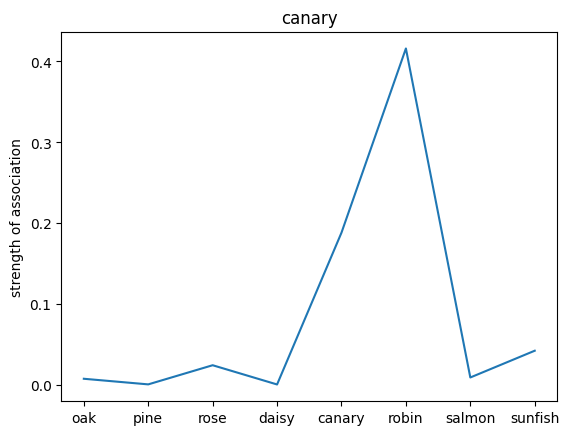

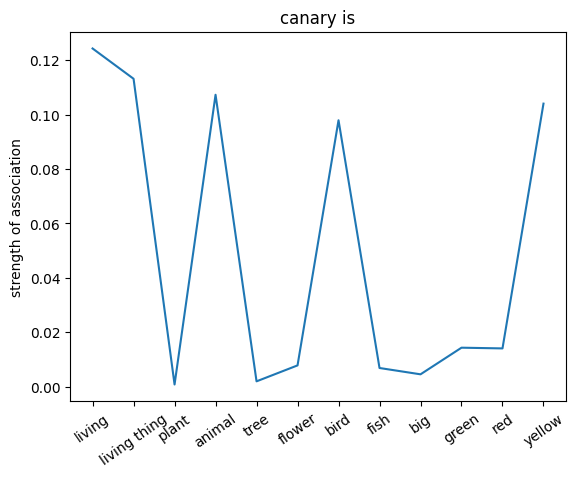

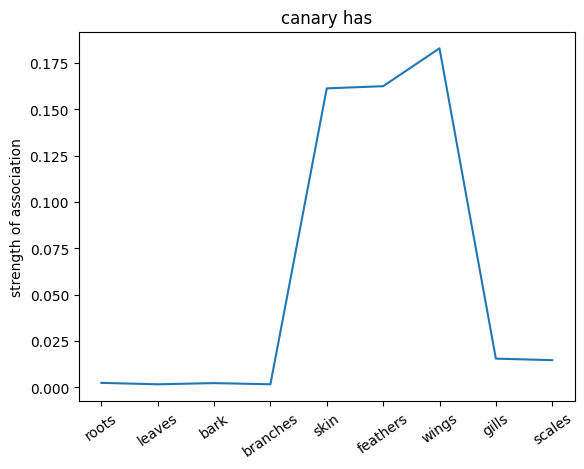

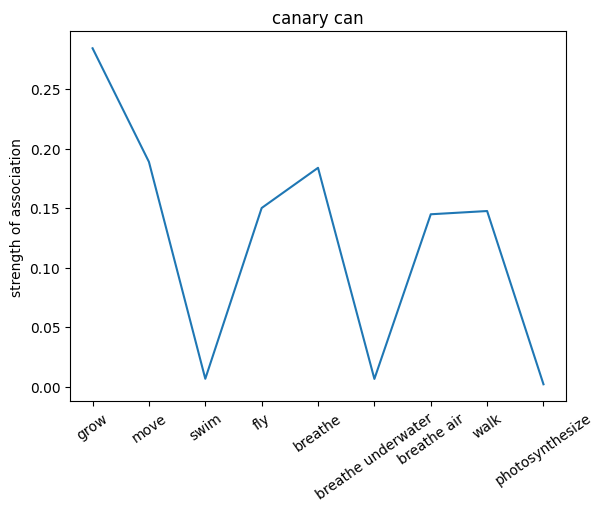

In [218]:
plt.plot(noun_out_I)
plt.xticks(np.arange(8),nouns)
plt.title(nouns[noun_id])
plt.ylabel('strength of association')
plt.show()


plt.plot(noun_out_is)
plt.xticks(np.arange(len(is_list)),is_list,rotation=35)
plt.title(nouns[noun_id] +' is')
plt.ylabel('strength of association')
plt.show()
plt.plot(noun_out_has)
plt.xticks(np.arange(len(has_list)),has_list,rotation=35)
plt.title(nouns[noun_id]+ ' has')
plt.ylabel('strength of association')
plt.show()
plt.plot(noun_out_can)
plt.xticks(np.arange(len(can_list)),can_list,rotation=35)
plt.title(nouns[noun_id]+' can')
plt.ylabel('strength of association')
plt.show()


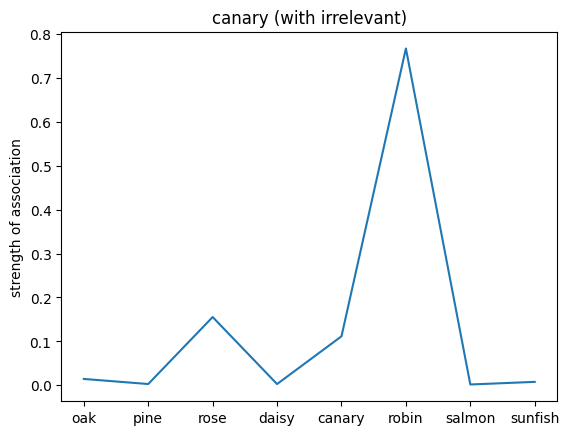

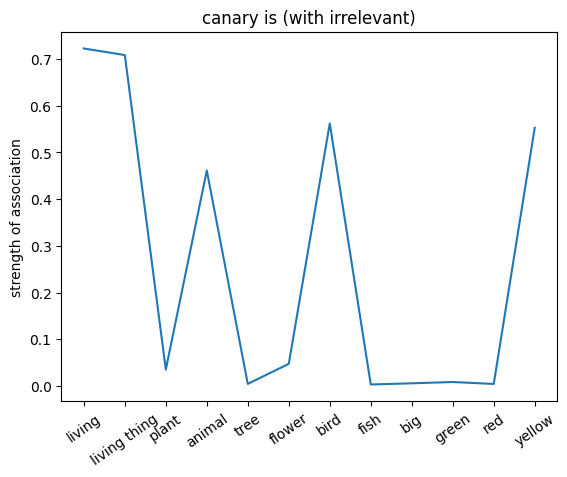

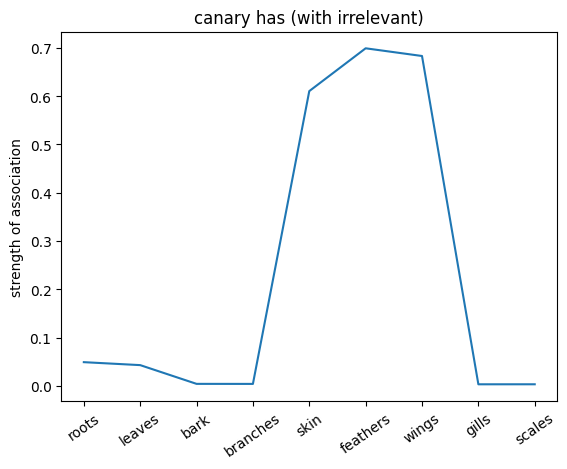

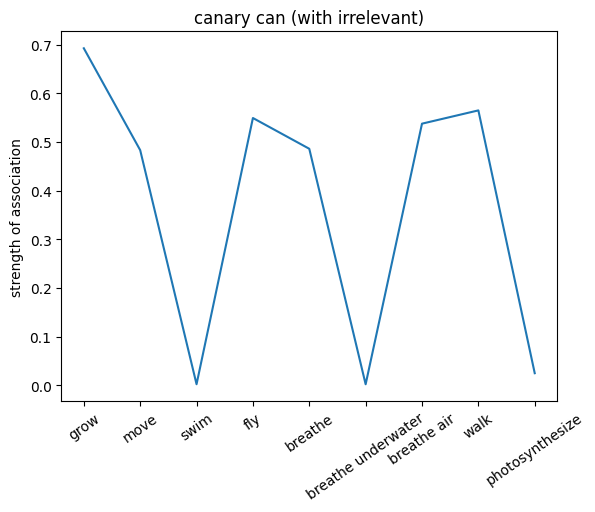

In [219]:
plt.plot(noun_out_I_with_ir)
plt.xticks(np.arange(8),nouns)
plt.title(f'{nouns[noun_id]} (with irrelevant)')
plt.ylabel('strength of association')
plt.show()


plt.plot(noun_out_is_with_ir)
plt.xticks(np.arange(len(is_list)),is_list,rotation=35)
plt.title(f'{nouns[noun_id]} is (with irrelevant)')
plt.ylabel('strength of association')
plt.show()
plt.plot(noun_out_has_with_ir)
plt.xticks(np.arange(len(has_list)),has_list,rotation=35)
plt.title(f'{nouns[noun_id]} has (with irrelevant)')
plt.ylabel('strength of association')
plt.show()
plt.plot(noun_out_can_with_ir)
plt.xticks(np.arange(len(can_list)),can_list,rotation=35)
plt.title(f'{nouns[noun_id]} can (with irrelevant)')
plt.ylabel('strength of association')
plt.show()


#### Exercise 4{exercise}

Exercise 4a

Compare the associations between the two networks. What do you observe?

Solution 4a{solution}

The network trained on the irrelevant outputs have overall stronger associations. This is because the network is not penalized for giving irrelevant outputs, and thus can learn stronger associations between the nouns and the relations.

**Note:** Not setting the irrelevant targets to 0 but a lower value can help the network to learn and converge faster since it can learn to give more weight to the associated values (even when they are not relevant to the exact input).



Exercise 4b

Try setting the discount factor to different values and try to predict the associations (you can lower the number of training trials). What do you observe?


Solution 4b{solution}

The lower the discount factor (the more discounting) the lower the associations.